In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import pickle
import pandas as pd

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split 
from tqdm import tqdm
import torch.optim as optim

from utils.models import CNN, MLP, DeepCNN
from utils.train_val_test import train_epoch, test, display_losses
from utils.dataset import MatricesDataset


In [22]:
config = {
    'dataset':{
        'target_name': 'h11',
        'class_label': 'original',
        'capacity': 'full',
        'test_size': 0.3,
        'train_batch': 16000,
        'validation_batch': 16000,
        'test_batch': 16000,
    },
    'model':{
        'device': 'cuda',
        'name': 'DeepCNN'
    },
    'train':{
        'num_epochs': 40,
        'learning_rate': 1e-3,
    },
    'MLP':{
        'input_size': 320,
        'hidden_size_1': 1024,
        'hidden_size_2': 512,
        'output_size': 1,
        'dropout': 0.2
    }
}

# Dataset

In [23]:
with open('data/padded_matrices', 'rb') as f:
    matrices = pickle.load(f)

df = pd.read_csv('data/cicy4folds_extended.csv')
df = df.replace('Null', np.nan)
nan_indeces = df.index[df.isna().any(axis=1)].tolist()

df_clear = df.drop(nan_indeces)
matrices_clear = np.delete(matrices, nan_indeces, axis=0)

assert len(df_clear)==len(matrices_clear)

In [24]:
df_train, df_test_validate, matrices_train, matrices_test_validate = train_test_split(df_clear, matrices_clear, test_size=config['dataset']['test_size'], shuffle=True)
df_test, df_validate, matrices_test, matrices_validate = train_test_split(df_test_validate, matrices_test_validate, test_size=config['dataset']['test_size'], shuffle=True)

In [25]:
train_ds = MatricesDataset(df_train, matrices_train, config['dataset']['target_name'])
validate_ds = MatricesDataset(df_validate, matrices_validate, config['dataset']['target_name'])
test_ds = MatricesDataset(df_test, matrices_test, config['dataset']['target_name'])

train_dataloader = DataLoader(train_ds, batch_size=config['dataset']['train_batch'])
test_dataloader = DataLoader(test_ds, batch_size=config['dataset']['test_batch'])
validate_dataloader = DataLoader(validate_ds, batch_size=config['dataset']['validation_batch'])

# Model

In [26]:
if (config['model']['name']=='CNN'):
    model = CNN().to(config['model']['device'])
elif (config['model']['name']=='MLP'):
    model = MLP(config).to(config['model']['device'])
elif (config['model']['name']=='DeepCNN'):
    model = DeepCNN().to(config['model']['device'])
else:
    raise NameError(f"There isn't model with name {config['model']['name']}")

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), config['train']['learning_rate'])

In [27]:
train_loss = []
val_loss = []
for epoch in tqdm(range(config['train']['num_epochs'])):
    losses = train_epoch(model, optimizer, criterion, train_dataloader, validate_dataloader, config)
    print(f"{epoch+1}: loss on train: {losses['train_loss']:.4f}, loss on validation: {losses['validation_loss']:.4f}")
    train_loss.append(losses['train_loss'])
    val_loss.append(losses['validation_loss'])
torch.save(model.state_dict(), f"models/{config['model']['name']}_for_{config['dataset']['target_name']}.pth")

  2%|█▋                                                                 | 1/40 [01:26<56:18, 86.63s/it]

1: loss on train: 29.9613, loss on validation: 4.2707


  5%|███▎                                                               | 2/40 [02:54<55:14, 87.22s/it]

2: loss on train: 3.3962, loss on validation: 3.0830


  8%|█████                                                              | 3/40 [04:21<53:53, 87.39s/it]

3: loss on train: 2.9712, loss on validation: 2.8393


 10%|██████▋                                                            | 4/40 [05:49<52:26, 87.40s/it]

4: loss on train: 2.6977, loss on validation: 2.5363


 12%|████████▍                                                          | 5/40 [07:16<50:59, 87.40s/it]

5: loss on train: 2.2773, loss on validation: 1.9987


 15%|██████████                                                         | 6/40 [08:44<49:35, 87.53s/it]

6: loss on train: 1.8847, loss on validation: 1.7796


 18%|███████████▋                                                       | 7/40 [10:12<48:10, 87.60s/it]

7: loss on train: 1.7393, loss on validation: 1.6738


 20%|█████████████▍                                                     | 8/40 [11:39<46:42, 87.58s/it]

8: loss on train: 1.6461, loss on validation: 1.5912


 22%|███████████████                                                    | 9/40 [13:07<45:15, 87.60s/it]

9: loss on train: 1.5686, loss on validation: 1.5427


 25%|████████████████▌                                                 | 10/40 [14:34<43:45, 87.51s/it]

10: loss on train: 1.5066, loss on validation: 1.4728


 28%|██████████████████▏                                               | 11/40 [16:02<42:20, 87.62s/it]

11: loss on train: 1.4577, loss on validation: 1.4089


 30%|███████████████████▊                                              | 12/40 [17:29<40:49, 87.47s/it]

12: loss on train: 1.4139, loss on validation: 1.4014


 32%|█████████████████████▍                                            | 13/40 [18:57<39:21, 87.47s/it]

13: loss on train: 1.3838, loss on validation: 1.3605


 35%|███████████████████████                                           | 14/40 [20:24<37:53, 87.43s/it]

14: loss on train: 1.3282, loss on validation: 1.2667


 38%|████████████████████████▊                                         | 15/40 [21:52<36:26, 87.47s/it]

15: loss on train: 1.2725, loss on validation: 1.2843


 40%|██████████████████████████▍                                       | 16/40 [23:19<34:57, 87.41s/it]

16: loss on train: 1.2299, loss on validation: 1.2276


 42%|████████████████████████████                                      | 17/40 [24:46<33:27, 87.30s/it]

17: loss on train: 1.1949, loss on validation: 1.1970


 45%|█████████████████████████████▋                                    | 18/40 [26:13<31:59, 87.26s/it]

18: loss on train: 1.2153, loss on validation: 1.1327


 48%|███████████████████████████████▎                                  | 19/40 [27:40<30:33, 87.32s/it]

19: loss on train: 1.1377, loss on validation: 1.1893


 50%|█████████████████████████████████                                 | 20/40 [29:08<29:07, 87.35s/it]

20: loss on train: 1.1620, loss on validation: 1.1476


 52%|██████████████████████████████████▋                               | 21/40 [30:35<27:40, 87.38s/it]

21: loss on train: 1.1018, loss on validation: 1.0574


 55%|████████████████████████████████████▎                             | 22/40 [32:03<26:12, 87.34s/it]

22: loss on train: 1.1295, loss on validation: 1.1297


 57%|█████████████████████████████████████▉                            | 23/40 [33:30<24:44, 87.33s/it]

23: loss on train: 1.0605, loss on validation: 1.0230


 60%|███████████████████████████████████████▌                          | 24/40 [34:57<23:16, 87.26s/it]

24: loss on train: 1.0912, loss on validation: 1.0522


 62%|█████████████████████████████████████████▎                        | 25/40 [36:24<21:49, 87.27s/it]

25: loss on train: 1.0390, loss on validation: 0.9932


 65%|██████████████████████████████████████████▉                       | 26/40 [37:52<20:23, 87.36s/it]

26: loss on train: 1.0301, loss on validation: 0.9708


 68%|████████████████████████████████████████████▌                     | 27/40 [39:19<18:56, 87.41s/it]

27: loss on train: 1.0112, loss on validation: 0.9450


 70%|██████████████████████████████████████████████▏                   | 28/40 [40:47<17:28, 87.37s/it]

28: loss on train: 1.0170, loss on validation: 0.9369


 72%|███████████████████████████████████████████████▊                  | 29/40 [42:16<16:05, 87.82s/it]

29: loss on train: 0.9657, loss on validation: 1.0243


 75%|█████████████████████████████████████████████████▌                | 30/40 [43:43<14:36, 87.61s/it]

30: loss on train: 0.9982, loss on validation: 0.9262


 78%|███████████████████████████████████████████████████▏              | 31/40 [45:10<13:07, 87.50s/it]

31: loss on train: 0.9403, loss on validation: 0.8946


 80%|████████████████████████████████████████████████████▊             | 32/40 [46:37<11:40, 87.51s/it]

32: loss on train: 0.9283, loss on validation: 0.8667


 82%|██████████████████████████████████████████████████████▍           | 33/40 [48:05<10:12, 87.52s/it]

33: loss on train: 0.9245, loss on validation: 0.8658


 85%|████████████████████████████████████████████████████████          | 34/40 [49:32<08:44, 87.39s/it]

34: loss on train: 0.9031, loss on validation: 0.8325


 88%|█████████████████████████████████████████████████████████▊        | 35/40 [50:59<07:16, 87.37s/it]

35: loss on train: 0.8970, loss on validation: 0.8687


 90%|███████████████████████████████████████████████████████████▍      | 36/40 [52:27<05:49, 87.39s/it]

36: loss on train: 0.8719, loss on validation: 0.8237


 92%|█████████████████████████████████████████████████████████████     | 37/40 [53:54<04:22, 87.43s/it]

37: loss on train: 0.8628, loss on validation: 0.8407


 95%|██████████████████████████████████████████████████████████████▋   | 38/40 [55:22<02:54, 87.49s/it]

38: loss on train: 0.8354, loss on validation: 0.7848


 98%|████████████████████████████████████████████████████████████████▎ | 39/40 [56:50<01:27, 87.57s/it]

39: loss on train: 0.8323, loss on validation: 0.7702


100%|██████████████████████████████████████████████████████████████████| 40/40 [58:21<00:00, 87.54s/it]

40: loss on train: 0.8184, loss on validation: 0.7714


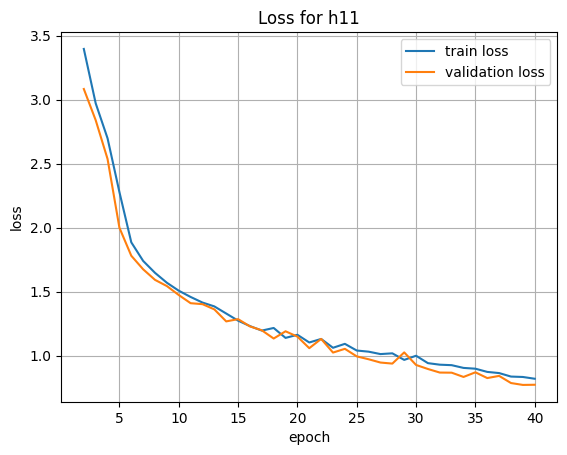

In [28]:
display_losses(train_loss, val_loss, config)

# Evaluation

In [29]:
model.load_state_dict(torch.load(f"models/{config['model']['name']}_for_{config['dataset']['target_name']}.pth"))

<All keys matched successfully>

In [30]:
test_metrics = test(model, criterion, test_dataloader, config)
print(f"loss on test: {test_metrics['test_loss']:.3f}, accuracy on test: {test_metrics['test_accuracy']*100:.2f}%")

100%|██████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.94s/it]

loss on test: 0.783, accuracy on test: 61.82%


In [33]:
#new_dataframe_result = pd.DataFrame(columns=['h11', 'h21', 'h31', 'h22'], index=['CNN', 'MLP', 'DeepCNN'])
#dataframe_result.to_csv(f"results/{config['dataset']['class_label']}_{config['dataset']['capacity']}_dataset.csv")

In [85]:
dataframe_result = pd.read_csv(f"results/{config['dataset']['class_label']}_{config['dataset']['capacity']}_dataset.csv", index_col=0)
dataframe_result[config['dataset']['target_name']][config['model']['name']] = round(test_metrics['test_accuracy'].item(),3)
dataframe_result.to_csv(f"results/{config['dataset']['class_label']}_{config['dataset']['capacity']}_dataset.csv")
dataframe_result

,h11,h21,h31,h22
CNN,0.702,0.632,0.152,0.033
MLP,0.033,0.640,0.028,0.002
DeepCNN,0.618,NaN,NaN,NaN


# Some waste

In [16]:
batch = next(iter(test_dataloader))
model_out = model(batch['matrix'].to(config['model']['device'])).squeeze(-1)
ground_truth = batch['hodge_number'].to(config['model']['device'])

In [17]:
model_out[:14].round()

tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.],
       device='cuda:0', grad_fn=<RoundBackward0>)

In [18]:
ground_truth[:14]

tensor([ 8., 11.,  8., 10., 14., 14., 12., 13., 10., 13.,  6.,  9., 10., 11.],
       device='cuda:0')

In [19]:
(model_out.round()==ground_truth).sum().item(), len(ground_truth)

(2629, 16000)